In [59]:

%reload_ext autoreload
%autoreload 2

import pyclesperanto as cle
import napari
from napari.types import ImageData, LabelsData
from mt.utils import load_scan, reslice
from magicgui import magicgui
from matplotlib import pyplot as plt
import numpy as np
cle.select_device("RTX")

(OpenCL) NVIDIA GeForce RTX 3060 Laptop GPU (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              516.95
	Device Type:                 GPU
	Compute Units:               30
	Global Memory Size:          6143 MB
	Maximum Object Size:         1535 MB
	Max Clock Frequency:         1425 MHz
	Image Support:               Yes

In [3]:
path = "../../04_uCT/AD36/"

In [4]:
# im = imread("test.tif")


In [5]:
im = load_scan(path, logging=True, image_range=None).scan
im = reslice(im)[95:105]

Loading images from:  ../../04_uCT/AD36/Slices/
Loaded stack with shape (1780, 205, 2214) and a size of 1.62 GB in 2.26 s.


<Image layer 'original' at 0x12fba39cb90>

In [7]:
im_default = cle.eroded_otsu_labeling(im, number_of_erosions=0, outline_sigma=0.1)


<Labels layer 'im_default' at 0x12eb33b8c90>

In [29]:
im_def = cle.pull(im_default)
len(np.unique(im_def))

12199

In [33]:
@magicgui(auto_call=True)
def otsu_labeling(im: ImageData,
                  sigma: float = 0.1,
                  n_erosions: int = 2,
                  dilation_radius: int = 1) -> LabelsData:
    im = cle.gaussian_blur(im, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)
    im = cle.threshold_otsu(im)
    if n_erosions>0:
        original_mask = cle.copy(im)
    for _ in range(n_erosions):
        im = cle.erode_labels(im, radius=1)
    if n_erosions > 0:
        im = cle.masked_voronoi_labeling(im, mask=original_mask)
    im = cle.dilate_labels(im, radius=dilation_radius)
    im = cle.erode_connected_labels(im, radius=1)
    return im

im_self = otsu_labeling(im)

In [32]:

viewer = napari.Viewer()
viewer.add_image(im, name="original")
viewer.window.add_dock_widget(otsu_labeling)
viewer.add_labels(im_default)


<Labels layer 'im_default' at 0x12fc7a7c090>

In [11]:
viewer.camera.zoom = 4

In [34]:
stat = cle.statistics_of_labelled_pixels(im_self, intensity=im)

In [41]:
from pprint import pprint
pprint(stat.keys())
len(np.unique(im_self))

dict_keys(['sum_z', 'label', 'sum_intensity_times_z', 'bbox_min_x', 'bbox_min_y', 'sum_intensity_times_x', 'bbox_depth', 'bbox_min_z', 'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'min_intensity', 'bbox_width', 'mass_center_x', 'bbox_height', 'area', 'sum_intensity_times_y', 'max_intensity', 'sum_intensity', 'mean_intensity', 'mass_center_y', 'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid', 'sum_distance_to_mass_center', 'mean_distance_to_mass_center', 'standard_deviation_intensity', 'max_distance_to_centroid', 'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio', 'mean_max_distance_to_mass_center_ratio'])


7573

In [58]:
df = pd.DataFrame(stat))

NameError: name 'pd' is not defined

In [46]:
areas = np.array(stat["area"])
areas = areas[areas > 100]

In [56]:
im_self = cle.pull(im_self)
particle = np.where(im_self == 1, 1, 0)
particle.shape

(10, 1780, 2214)

2.0

In [57]:
viewer = napari.Viewer()
viewer.add_image(particle, name="particle")

<Image layer 'particle' at 0x12fc9ff6410>

(array([1.002e+03, 1.051e+03, 7.870e+02, 4.800e+02, 3.720e+02, 2.950e+02,
        2.360e+02, 1.770e+02, 1.620e+02, 1.430e+02, 1.240e+02, 1.200e+02,
        1.200e+02, 8.300e+01, 1.020e+02, 8.400e+01, 8.200e+01, 6.600e+01,
        7.200e+01, 5.300e+01, 6.300e+01, 7.800e+01, 3.100e+01, 4.600e+01,
        5.100e+01, 5.400e+01, 4.400e+01, 4.600e+01, 5.900e+01, 4.900e+01,
        4.000e+01, 4.900e+01, 5.200e+01, 4.200e+01, 4.500e+01, 5.200e+01,
        3.800e+01, 3.100e+01, 3.800e+01, 3.200e+01, 4.100e+01, 2.500e+01,
        3.500e+01, 3.100e+01, 2.200e+01, 2.400e+01, 2.300e+01, 2.800e+01,
        1.400e+01, 1.300e+01, 1.900e+01, 1.500e+01, 9.000e+00, 1.400e+01,
        9.000e+00, 1.400e+01, 1.400e+01, 7.000e+00, 5.000e+00, 9.000e+00,
        8.000e+00, 7.000e+00, 6.000e+00, 5.000e+00, 3.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+0

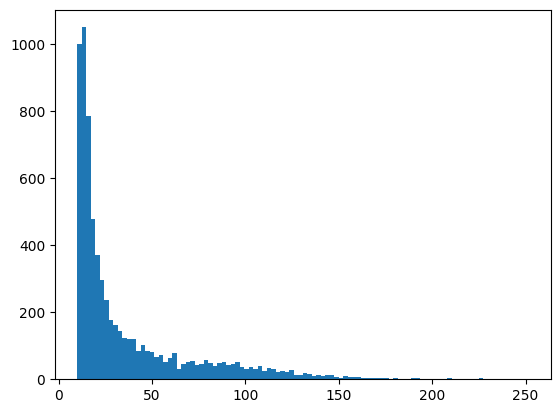

In [50]:
plt.hist(np.sqrt(areas), bins=100)